In [1]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import pickle
import librosa
import random
import glob
import soundfile as sf
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

## Network Compression Using SVD: Low Rank Approximation of Weight Matrices 

### Baseline Model and Accuracy

In [50]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

In [51]:
train_images = train_images.reshape(-1, 28*28).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28*28).astype('float32') / 255.0

In [52]:
def create_baseline():
    mnist_baseline = models.Sequential()

    mnist_baseline.add(layers.Dense(1024, input_shape=(784,)))
    mnist_baseline.add(layers.BatchNormalization())
    mnist_baseline.add(layers.ReLU())
    mnist_baseline.add(layers.Dropout(0.4))

    for _ in range(4):
        mnist_baseline.add(layers.Dense(1024))
        mnist_baseline.add(layers.BatchNormalization())
        mnist_baseline.add(layers.ReLU())
        mnist_baseline.add(layers.Dropout(0.4))

    mnist_baseline.add(layers.Dense(10, activation='softmax'))
    
    return mnist_baseline

In [53]:
mnist_baseline = create_baseline()
mnist_baseline.compile(optimizer=optimizers.Adam(learning_rate=0.01), 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])

In [54]:
history_mnist_baseline = mnist_baseline.fit(train_images, train_labels,
                                            epochs=30,
                                            batch_size=512,
                                            validation_data=(test_images, test_labels))

Epoch 1/30


I0000 00:00:1731267918.038130 3639726 service.cc:146] XLA service 0x70dfd0bcdcd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731267918.038186 3639726 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1731267918.038194 3639726 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1731267918.038200 3639726 service.cc:154]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1731267918.038205 3639726 service.cc:154]   StreamExecutor device (3): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5


 28/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6225 - loss: 1.3897

I0000 00:00:1731267922.451015 3639726 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8079 - loss: 0.6879 - val_accuracy: 0.9141 - val_loss: 0.5177
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9544 - loss: 0.1524 - val_accuracy: 0.9698 - val_loss: 0.1224
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9621 - loss: 0.1234 - val_accuracy: 0.9579 - val_loss: 0.1618
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9693 - loss: 0.1055 - val_accuracy: 0.9765 - val_loss: 0.0902
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9749 - loss: 0.0837 - val_accuracy: 0.9780 - val_loss: 0.0886
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9760 - loss: 0.0780 - val_accuracy: 0.9777 - val_loss: 0.0829
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9793 - loss: 0.0685 - val_accuracy: 0.9802 - val_loss: 0.0692
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9806 - loss: 0.0626 - val_accuracy: 0.9809 - va

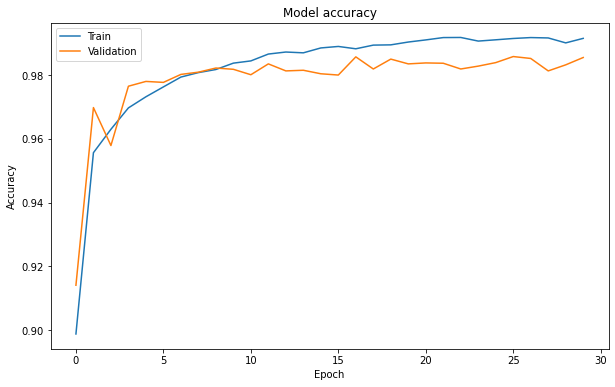

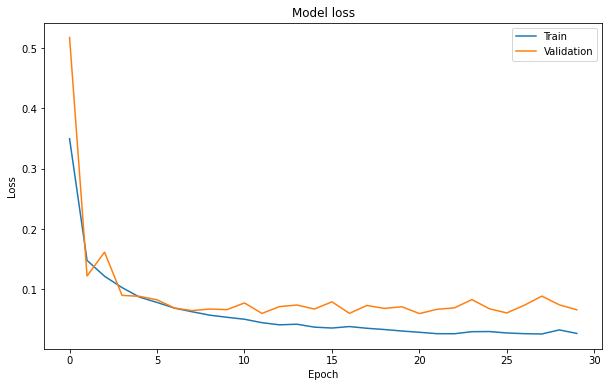

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(history_mnist_baseline.history['accuracy'])
plt.plot(history_mnist_baseline.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history_mnist_baseline.history['loss'])
plt.plot(history_mnist_baseline.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

### SVD Compressed Models

In [56]:
def apply_svd_compression(layer_weights, D):
    S, U, V = tf.linalg.svd(layer_weights, full_matrices=False)
    U_reduced = U[:, :D]
    S_reduced = tf.linalg.diag(S[:D])
    V_reduced = V[:, :D]
    W_compressed = tf.matmul(U_reduced, tf.matmul(S_reduced, tf.transpose(V_reduced)))
    return W_compressed

In [57]:
def calculate_compression_info(original_model, D):
    """Calculate number of parameters and compression ratio for given D."""
    original_params = 0
    compressed_params = 0
    
    for l, layer in enumerate(original_model.layers):
        if isinstance(layer, tf.keras.layers.Dense) and l < len(original_model.layers) - 1:
            W = layer.get_weights()[0]
            b = layer.get_weights()[1]
            m, n = W.shape
            
            # original parameters (weights + biases)
            original_params += m * n + len(b)
            
            # first layer (l=0), D_full = 784; for others, D_full = 1024
            D_full = 784 if l == 0 else 1024
            
            # D cannot exceed D_full or matrix dimensions
            effective_D = min(D, D_full, m, n)
            
            # SVD parameters: U(m×D) + S(D) + V(n×D) + original biases
            compressed_params += m * effective_D + effective_D + n * effective_D + len(b)
    
    return original_params, compressed_params

In [58]:
def evaluate_compression(model, test_images, test_labels, D_values):
    """Evaluate model for different compression levels"""
    results = {'D': [], 'accuracy': [], 'original_params': [], 'compressed_params': []}
    
    # evaluation model
    eval_model = create_baseline()
    eval_model.compile(optimizer=optimizers.Adam(learning_rate=0.01), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
    
    # baseline accuracy with original weights
    baseline_accuracy = model.evaluate(test_images, test_labels, verbose=0)[1]
    original_params, _ = calculate_compression_info(model, 1024)
    
    print(f"\nBaseline accuracy: {baseline_accuracy:.4f}, Original Parameters: {original_params}")   
    
    original_weights = [layer.get_weights() for layer in model.layers]
    
    for D in D_values:
        print(f"\nCompressing with D={D}")
        
        for i, layer in enumerate(eval_model.layers):
            if isinstance(layer, tf.keras.layers.Dense):
                weights = original_weights[i]
                
                # D_full based on layer index (input layer vs hidden layers)
                D_full = 784 if i == 0 else 1024
                
                if i < len(model.layers) - 1:  # skip last layer
                    effective_D = min(D, D_full)
                    compressed_weights = apply_svd_compression(weights[0], effective_D)
                    layer.set_weights([compressed_weights, weights[1]])
                else:
                    layer.set_weights(weights)
            else:
                # keep original weights for non-Dense layers
                layer.set_weights(original_weights[i])
        
        accuracy = eval_model.evaluate(test_images, test_labels, verbose=0)[1]
        _, compressed_params = calculate_compression_info(eval_model, D)
        
        results['D'].append(D)
        results['accuracy'].append(accuracy)
        results['original_params'].append(original_params)
        results['compressed_params'].append(compressed_params)
        
        print(f"Test accuracy: {accuracy:.4f}, Compressed Parameters: {compressed_params}, Compression Ratio: {original_params / compressed_params:.2f}x")
    
    plt.figure(figsize=(10, 6))
    plt.semilogx(results['D'], results['accuracy'], 'bo-')
    plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
    plt.xlabel('D (number of singular values)')
    plt.ylabel('Test Accuracy')
    plt.title('Accuracy vs Compression Level')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(results['D'], results['compressed_params'], 'bo-', label='Compressed Parameters')
    plt.axhline(y=original_params, color='r', linestyle='--', label='Baseline Parameters')
    plt.xscale('log')
    plt.xlabel('D (number of singular values)')
    plt.ylabel('Number of Parameters')
    plt.title('Compressed Parameters vs Baseline Parameters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

### Test Acccuracies of the SVDed Models and Comparison of the Number of Parameters 


Baseline accuracy: 0.9855, Original Parameters: 5002240

Compressing with D=10
Test accuracy: 0.6786, Compressed Parameters: 105170, Compression Ratio: 47.56x

Compressing with D=20
Test accuracy: 0.9386, Compressed Parameters: 205220, Compression Ratio: 24.38x

Compressing with D=50
Test accuracy: 0.9800, Compressed Parameters: 505370, Compression Ratio: 9.90x

Compressing with D=100
Test accuracy: 0.9842, Compressed Parameters: 1005620, Compression Ratio: 4.97x

Compressing with D=200
Test accuracy: 0.9851, Compressed Parameters: 2006120, Compression Ratio: 2.49x

Compressing with D=1024
Test accuracy: 0.9855, Compressed Parameters: 9816080, Compression Ratio: 0.51x


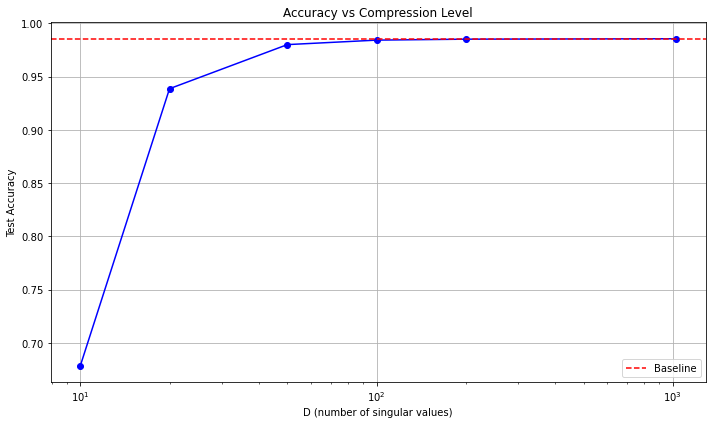

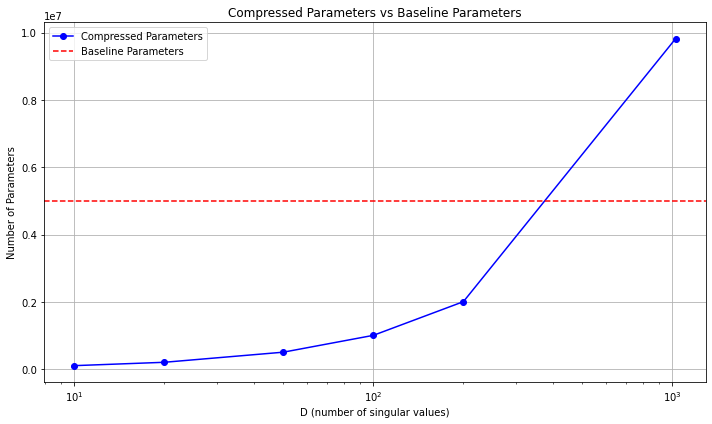

In [59]:
D_values = [10, 20, 50, 100, 200, 1024]
results = evaluate_compression(mnist_baseline, test_images, test_labels, D_values)

In [60]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='accuracy', ascending=False)
print(df_results)

      D  accuracy  original_params  compressed_params
5  1024    0.9855          5002240            9816080
4   200    0.9851          5002240            2006120
3   100    0.9842          5002240            1005620
2    50    0.9800          5002240             505370
1    20    0.9386          5002240             205220
0    10    0.6786          5002240             105170


- The first plot shows the test accuracies of the six SVDed versions benchmarked against the baseline performance.
- The second graph reports the number of parameters  of the SVDed networks compared to the number of parameters of the baseline. 

## Network Compression Using SVD: Estimating Weight Matrices Using their Factor Matrices

### Definition and Initialization of the New SVD Model

In [81]:
class FactorizedDense(layers.Layer):
    def __init__(self, units, rank=20, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.rank = rank

    def build(self, input_shape):
        input_dim = input_shape[-1]
        
        # Initialize U and V matrices
        self.U = self.add_weight(
            name='U',
            shape=(input_dim, self.rank),
            initializer='glorot_uniform',
            trainable=True
        )
        
        self.V = self.add_weight(
            name='V',
            shape=(self.units, self.rank),
            initializer='glorot_uniform',
            trainable=True
        )
        
        self.bias = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        # W = UV^T
        reconstructed_weights = tf.matmul(self.U, tf.transpose(self.V))
        return tf.matmul(inputs, reconstructed_weights) + self.bias

    def get_config(self):
        config = super().get_config()
        config.update({
            'units': self.units,
            'rank': self.rank
        })
        return config

In [74]:
def create_factorized_network():
    model = models.Sequential()
    
    model.add(FactorizedDense(1024, rank=20, input_shape=(784,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.4))
    
    for _ in range(4):
        model.add(FactorizedDense(1024, rank=20))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.Dropout(0.4))
    
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [82]:
def initialize_from_svd(baseline_model, factorized_model, D=20):
    baseline_weights = [layer.get_weights() for layer in baseline_model.layers]
    factorized_idx = 0
    
    for i, layer in enumerate(baseline_model.layers):
        if isinstance(layer, layers.Dense) and i < len(baseline_model.layers) - 1:
            W = baseline_weights[i][0]
            b = baseline_weights[i][1]
            
            # SVD
            S, U, V = tf.linalg.svd(W, full_matrices=False)
            
            U_init = U[:, :D]  # Shape: [input_dim, D]
            V_init = tf.matmul(V[:, :D], tf.linalg.diag(S[:D]))  # Shape: [output_dim, D]
            
            # corresponding factorized layer
            factorized_layer = factorized_model.layers[factorized_idx * 4]
            
            # weights with correct shapes
            factorized_layer.U.assign(U_init)
            factorized_layer.V.assign(V_init)
            factorized_layer.bias.assign(b)
            
            factorized_idx += 1
        elif i == len(baseline_model.layers) - 1:
            # output layer weights
            factorized_model.layers[-1].set_weights(baseline_weights[i])

In [83]:
# Create and train the factorized model
factorized_model = create_factorized_network()
initialize_from_svd(mnist_baseline, factorized_model, D=20)

# Compile with a smaller learning rate
factorized_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the network
history_factorized = factorized_model.fit(
                    train_images, train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(test_images, test_labels)
)

# Evaluate final performance
test_loss, test_accuracy = factorized_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.4816 - loss: 2.4877 - val_accuracy: 0.9468 - val_loss: 0.2297
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9352 - loss: 0.2433 - val_accuracy: 0.9639 - val_loss: 0.1498
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9542 - loss: 0.1796 - val_accuracy: 0.9711 - val_loss: 0.1266
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9595 - loss: 0.1584 - val_accuracy: 0.9740 - val_loss: 0.1183
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9653 - loss: 0.1407 - val_accuracy: 0.9753 - val_loss: 0.1122
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9660 - loss: 0.1321 - val_accuracy: 0.9762 - val_loss: 0.1065
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9657 - loss: 0.1326 - val_accuracy: 0.9767 - val_loss: 0.1006
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9693 - loss: 0.1186 - val_ac

- Initializing the factorized weights with pre-trained values allows the network to start from a knowledgeable state, rather than random weights, leading to faster convergence and better accuracy.


### Test Accuracy

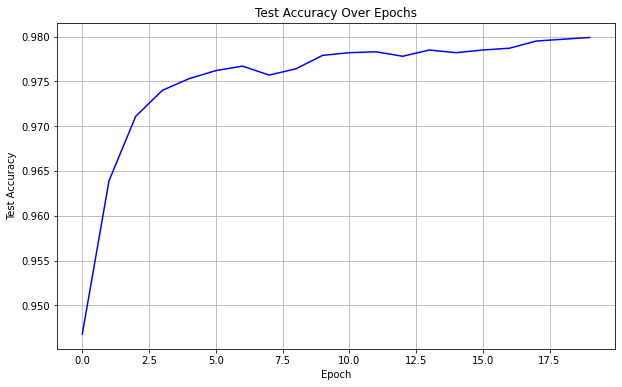

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(history_factorized.history['val_accuracy'], color='b')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

## Network Compression Using SVD: SVD at Every Iteration

### SVD Model

In [37]:
class SVDDenseLayer(layers.Layer):
    def __init__(self, units, rank=20, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.rank = rank

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )

    @tf.function
    def call(self, inputs):
        # Perform SVD at every iteration (forward pass)
        s, u, v = tf.linalg.svd(self.kernel, full_matrices=False)
        
        # Take only top D singular values/vectors
        u_reduced = u[:, :self.rank]
        s_reduced = s[:self.rank]
        v_reduced = v[:, :self.rank]
        
        # Reconstruct compressed weight matrix
        kernel_compressed = tf.matmul(
            u_reduced * tf.expand_dims(s_reduced, 0),
            tf.transpose(v_reduced)
        )
        
        return tf.matmul(inputs, kernel_compressed) + self.bias

In [38]:
def create_svd_network():
    model = models.Sequential([
        layers.Input(shape=(784,)),
        SVDDenseLayer(1024),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.4),
    ])
    

    for _ in range(4):
        model.add(SVDDenseLayer(1024))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.Dropout(0.4))
    
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [39]:
svd_model = create_svd_network()

In [40]:
@tf.function
def train_step(model, x_batch, y_batch, optimizer):
    with tf.GradientTape() as tape:
        logits = model(x_batch, training=True)
        loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(y_batch, logits)
        )
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, logits

In [41]:
def train_model(model, train_dataset, test_dataset, epochs=30):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    # history dictionary to store metrics
    history = {
        'loss': [],
        'accuracy': [],
        'val_accuracy': [],
        'val_loss': []
    }
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        
        # metrics
        epoch_loss = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
        # SVD happens in layer's call method at every iteration
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            loss, logits = train_step(model, x_batch, y_batch, optimizer)
            epoch_loss.update_state(loss)
            epoch_accuracy.update_state(y_batch, logits)
            
            if step % 50 == 0:
                print(f"Step {step}, "
                      f"Loss: {epoch_loss.result():.4f}, "
                      f"Accuracy: {epoch_accuracy.result():.4f}", end='\r')
        
        history['loss'].append(epoch_loss.result().numpy())
        history['accuracy'].append(epoch_accuracy.result().numpy())
        
        # Validation phase
        val_loss = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
        for x_test, y_test in test_dataset:
            val_logits = model(x_test, training=False)
            val_loss.update_state(
                tf.keras.losses.sparse_categorical_crossentropy(y_test, val_logits)
            )
            val_accuracy.update_state(y_test, val_logits)
        
        history['val_loss'].append(val_loss.result().numpy())
        history['val_accuracy'].append(val_accuracy.result().numpy())
        
        print(f"\nEpoch {epoch + 1}: "
              f"Loss: {epoch_loss.result():.4f}, "
              f"Accuracy: {epoch_accuracy.result():.4f}, "
              f"Val Loss: {val_loss.result():.4f}, "
              f"Val Accuracy: {val_accuracy.result():.4f}")
        
        # Early stopping
        if val_accuracy.result() >= 0.97:
            print("\nReached target accuracy of 97%. Stopping training.")
            break
    
    return history

### Test Accuracy

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels)
).shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

initialize_from_baseline(mnist_baseline, svd_model)

# Train
history = train_model(svd_model, train_dataset, test_dataset)


Epoch 1/30
Step 450, Loss: 0.6988, Accuracy: 0.9375
Epoch 1: Loss: 0.6978, Accuracy: 0.9377, Val Loss: 0.5373, Val Accuracy: 0.9481

Epoch 2/30
Step 450, Loss: 0.5186, Accuracy: 0.9445
Epoch 2: Loss: 0.5152, Accuracy: 0.9447, Val Loss: 0.4158, Val Accuracy: 0.9525

Epoch 3/30
Step 450, Loss: 0.4011, Accuracy: 0.9493
Epoch 3: Loss: 0.4012, Accuracy: 0.9494, Val Loss: 0.3350, Val Accuracy: 0.9550

Epoch 4/30
Step 450, Loss: 0.3244, Accuracy: 0.9515
Epoch 4: Loss: 0.3242, Accuracy: 0.9515, Val Loss: 0.2756, Val Accuracy: 0.9575

Epoch 5/30
Step 450, Loss: 0.2697, Accuracy: 0.9525
Epoch 5: Loss: 0.2686, Accuracy: 0.9526, Val Loss: 0.2289, Val Accuracy: 0.9591

Epoch 6/30


2024-11-10 02:36:58.403298: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 6: Loss: 0.2224, Accuracy: 0.9545, Val Loss: 0.1959, Val Accuracy: 0.9600

Epoch 7/30
Step 450, Loss: 0.1894, Accuracy: 0.9564
Epoch 7: Loss: 0.1884, Accuracy: 0.9567, Val Loss: 0.1717, Val Accuracy: 0.9610

Epoch 8/30
Step 450, Loss: 0.1726, Accuracy: 0.9569
Epoch 8: Loss: 0.1719, Accuracy: 0.9568, Val Loss: 0.1547, Val Accuracy: 0.9619

Epoch 9/30
Step 450, Loss: 0.1564, Accuracy: 0.9573
Epoch 9: Loss: 0.1561, Accuracy: 0.9574, Val Loss: 0.1424, Val Accuracy: 0.9632

Epoch 10/30
Step 450, Loss: 0.1464, Accuracy: 0.9584
Epoch 10: Loss: 0.1463, Accuracy: 0.9585, Val Loss: 0.1340, Val Accuracy: 0.9642

Epoch 11/30
Step 450, Loss: 0.1380, Accuracy: 0.9593
Epoch 11: Loss: 0.1380, Accuracy: 0.9593, Val Loss: 0.1283, Val Accuracy: 0.9647

Epoch 12/30
Step 450, Loss: 0.1331, Accuracy: 0.9604
Epoch 12: Loss: 0.1319, Accuracy: 0.9608, Val Loss: 0.1237, Val Accuracy: 0.9656

Epoch 13/30
Step 450, Loss: 0.1271, Accuracy: 0.9611
Epoch 13: Loss: 0.1269, Accuracy: 0.9613, Val Loss: 0.1198, V

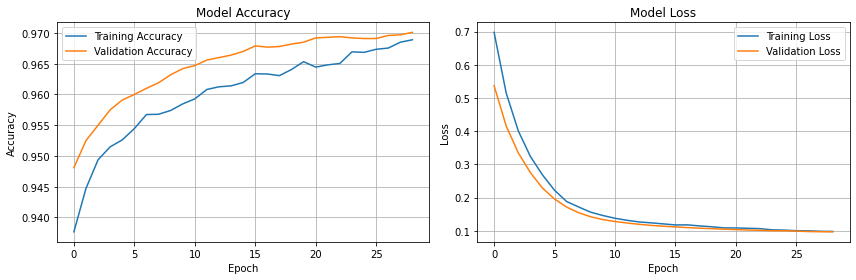

In [36]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
plot_history(history)